<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine 

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.base import BaseEstimator
import random
import torch.nn as nn
from torch.nn import ReLU
from math import ceil
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterSampler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
#загрузка файла, преобразование даты в формат DateTime и помещение даты в индекс.
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
#проведем сортировку индексов
data.sort_index(inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data['num_orders'].sort_values().unique()#выведем все уникальные значения столбца num_orders

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  60,  61,  62,  64,  65,  66,
        67,  68,  71,  76,  78,  80,  81,  82,  87,  90,  91,  94,  95,
        98,  99, 119])

Как видно из данных, есть некоторе количество отризательных значений поездок. Создадим функцию для того, чтобы заменить отрицательные значения на положительные.

In [4]:
# создадим функцию для того, чтобы заменить отрицательные значения на положительные. 
def my_max(a):
    if a > 0:
        return a
    else:
        return a*(-1)
data['num_orders'] = data['num_orders'].apply(my_max)

In [5]:
data['num_orders'].sort_values().unique()#выведем униальные значения после преобразования отриательных значений.

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  60,  61,  62,  64,  65,  66,
        67,  68,  71,  76,  78,  80,  81,  82,  87,  90,  91,  94,  95,
        98,  99, 119])

In [6]:
data.info()#выведем информаию о датасете

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
# сгруппируем по часам и посчитаем сумму заказов за час
data = data.resample('1H').sum()

In [8]:
data.info()#выведем информацию после ресемплинга

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [9]:
data.index.min()#выведем минимальный временной показатель

Timestamp('2018-03-01 00:00:00', freq='H')

In [10]:
data.index.max()#выведем максимальный временной покзатель

Timestamp('2018-08-31 23:00:00', freq='H')

**Вывод**  
Как видно из данных выше, в представленном датасете 26 496 строк, отсутствуют пустые значения. После ресемплирования строк в датасете стало 4 416. Период в датасете представлен с 2018-03-01 (00:00:00) до 2018-08-31(23:00:00). Целевой признак - num_orders.  


In [11]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [12]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


## Анализ

<Figure size 1080x576 with 0 Axes>

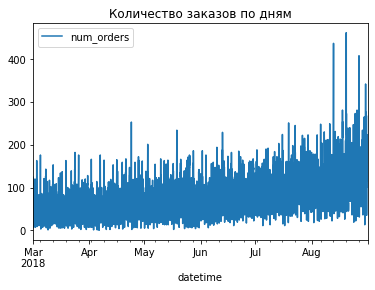

In [13]:
plt.figure(figsize = (15,8))
data.plot()
plt.title('Количество заказов по дням')
plt.show()

Как вдино из данных, временной ряд является нестационарным, имеет тренд.

<AxesSubplot:xlabel='datetime'>

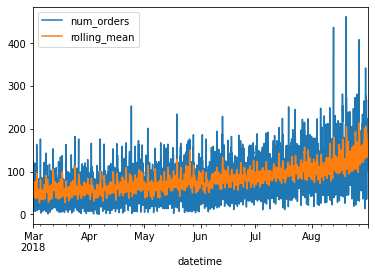

In [14]:
# Создадим столбец со скользящим средним и окном 10.
data_roll = data.copy()
data_roll['rolling_mean'] = data_roll.rolling(10).mean()# < напишите код здесь >
data_roll.plot()

Как видно из данных, приведенных выше, среднее количество заказов возрастает за анализируемый период.

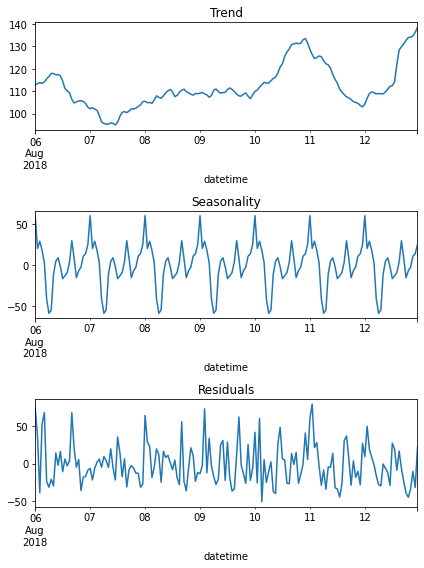

In [15]:
# Произвожу декомпозицию временного ряда, чтоб увидеть тренд, сезонность и белый шум
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend['2018-08-06':'2018-08-12'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-06':'2018-08-12'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-08-06':'2018-08-12'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Построили графики за неделю, в котором наблюдается сезонность внтури дня.

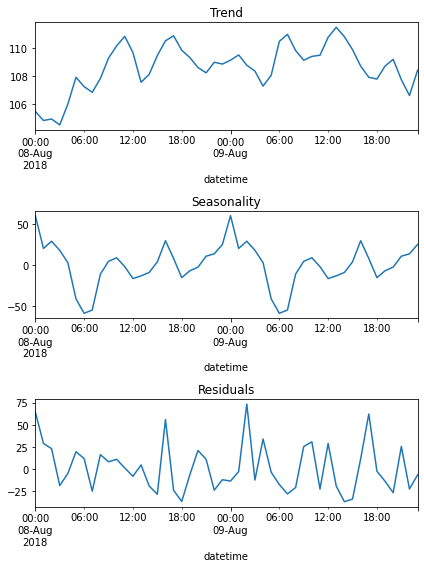

In [16]:
# Произвожу декомпозицию временного ряда, что увидеть тренд, сезонность и белый шум

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend['2018-08-08':'2018-08-09'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-08-08':'2018-08-09'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-08-08':'2018-08-09'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Как видно из графика за день, из графика сезонности видно, что наименьшее количество заказов в 6.00, а наибольшее количество заказов в 00:00.

In [17]:
# Подготовим функция для создания календарных признаков и отстающих значений
def make_features(data, max_lag, rolling_mean_size):
  
    data['Day']=data.index.day
    data['Day_of_week']=data.index.dayofweek
    
    for i in range(1,max_lag+1):
        data['lag_{}'.format(i)]=data['num_orders'].shift(i)
    data['rolling_mean']=data['num_orders'].shift().rolling(window=rolling_mean_size).mean()
    return data

## Обучение

Проведем подбор гиперпараметров модели на произвольном числе признаков. Возьмем, к примеру, max_lag  = 1 и rolling_mean_size = 24.

In [18]:
data_line = make_features(data,1,24)
data_line

,num_orders,Day,Day_of_week,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN
2018-03-01 02:00:00,71,1,3,85.0,NaN
2018-03-01 03:00:00,66,1,3,71.0,NaN
2018-03-01 04:00:00,43,1,3,66.0,NaN
...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,164.875000
2018-08-31 20:00:00,154,31,4,136.0,167.541667
2018-08-31 21:00:00,159,31,4,154.0,168.041667


In [19]:
# Произведем отделение тестовой части датасета 

train_valid, test = train_test_split(data, test_size=0.1, shuffle=False)

data_line = make_features(train_valid, 10, 9)

# произведем удаление NAN из датасета
data_line=data_line.dropna()

#определим целевой признак
target=data_line['num_orders']
features=data_line.drop(['num_orders'], axis=1)
# разделим выборку на валидацию и трейн
X_train, X_valid, y_train, y_valid = train_test_split(features, target, train_size=0.9, shuffle=False)

In [20]:
data_line

,num_orders,Day,Day_of_week,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
datetime,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,1,3,69.0,44.555556,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 11:00:00,96,1,3,64.0,42.222222,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 12:00:00,30,1,3,96.0,45.000000,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-01 13:00:00,32,1,3,30.0,41.000000,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-01 14:00:00,48,1,3,32.0,39.777778,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,13,0,91.0,162.222222,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0
2018-08-13 10:00:00,156,13,0,137.0,159.666667,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0
2018-08-13 11:00:00,144,13,0,156.0,146.666667,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0


Напишем пайплайн для подбора гиперпараметров моделей.

In [27]:
pipelines = []
params = []
names = []

In [28]:
pipeline_tree = Pipeline([('tree', None)])

pipeline_lgm = Pipeline([('lgm', None)])

pipeline_catboost = Pipeline([('cat', None)])

In [29]:
param_tree = [
    {'tree': (RandomForestRegressor(random_state=1),),
     'tree__n_estimators': range(1, 20, 20),
     'tree__max_depth': range(1, 20, 20),
     }
]

param_tree_default = [
    {'tree': (RandomForestRegressor(random_state=1),),     
     }
]

param_lgm = [
    {'lgm': (LGBMRegressor(random_state=1, learning_rate=0.1),),
     'lgm__n_estimators': [50, 100],
     'lgm__max_depth': [5, 10],
     }
]

param_lgm_default = [
    {'lgm': (LGBMRegressor(random_state=1),),}
]

param_catboost = [
     {'cat': (CatBoostRegressor(random_state=1, verbose=False),),
      }
 ]
param_catboost_1 = [
     {'cat': (CatBoostRegressor(random_state=1, verbose=False),),
     'cat__learning_rate': np.logspace(-4, -1, 5),
     'cat__iterations': range(25, 100, 75),
     'cat__depth': range(5,10,5),
     }
 ]

In [34]:
names = ['TREE' , "TREE_DEFAULT", "LGM", "LGM_DEFAULT", "CAT_BOOST", "CAT_BOOST_1"]

In [31]:
pipelines.append(pipeline_tree)
pipelines.append(pipeline_tree)
pipelines.append(pipeline_lgm)
pipelines.append(pipeline_lgm)
pipelines.append(pipeline_catboost)
pipelines.append(pipeline_catboost)

params.append(param_tree)
params.append(param_tree_default)
params.append(param_lgm)
params.append(param_lgm_default)
params.append(param_catboost)
params.append(param_catboost_1)


In [35]:
results = {}
for pipeline, param_grid, name in tqdm(zip(pipelines, params, names)):   
    gs = GridSearchCV(pipeline,
                  param_grid,
                  scoring='neg_root_mean_squared_error',
                  refit='neg_root_mean_squared_error',
                  n_jobs=-1,
                  cv=5 )
    
    gs.fit(X_train, y_train)  
    
    #top models table
    print('Top ' + name + ' models:')
    results_df = pd.DataFrame(gs.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_score"])
    display(results_df[['params', 'mean_test_score', 'mean_fit_time', 'rank_test_score']]
            .head(5)
            .rename(columns={'mean_test_score': 'cv_score'})
            .rename(columns={'rank_test_score': 'rank_cv_score'}))

    results[name] = gs




0it [00:00, ?it/s]

Top CAT_BOOST models:


,params,cv_score,mean_fit_time,rank_cv_score
0,{'cat': <catboost.core.CatBoostRegressor objec...,-27.779294,26.755236,1


Как видно из данных, приведенных выше, лучший показатель у модели CAT_BOOST. В данной связи сохраним ее гиперпараметры, как лучший результат.

In [36]:
X_valid['pred'] = results['CAT_BOOST'].best_estimator_.predict(X_valid)
X_valid[['pred']].to_csv('test_submission.csv', index=False)

In [37]:
X_valid['pred']

datetime
2018-07-28 01:00:00    125.946077
2018-07-28 02:00:00    169.840697
2018-07-28 03:00:00    141.211712
2018-07-28 04:00:00    110.449067
2018-07-28 05:00:00     93.471052
                          ...    
2018-08-13 09:00:00    108.937462
2018-08-13 10:00:00    118.717425
2018-08-13 11:00:00    124.436661
2018-08-13 12:00:00    118.945051
2018-08-13 13:00:00    119.408291
Freq: H, Name: pred, Length: 397, dtype: float64

Напишем функцию для подбора количества признаков временного ряда.

In [38]:
def perebor(d, model, min_lag=1, max_lag=50, step_lag=10, min_rolling_mean_size=1, rolling_mean_size=50, step_rolling_mean_size=10):
    best_rmse = -10
    best_lag = 0
    best_rol = 0
    c = 0
    lag_list = range(min_lag, max_lag, step_lag)
    rolling_list = range(min_rolling_mean_size, rolling_mean_size, step_rolling_mean_size)
    for l in lag_list:
        for r in rolling_list:

            print(f'Lag: {l}, Roll: {r}', end='\r', flush=False)
            d_1 = make_features(d, l, r)
            
            train, valid = train_test_split(d_1, shuffle=False, test_size=0.1)
            
            train = train.dropna()
            train_x = train.drop('num_orders', axis=1)
            train_y = train['num_orders']
            
            valid_x = valid.drop('num_orders', axis=1)
            valid_y = valid['num_orders']
            
            model.fit(train_x, train_y)
            pred = model.predict(valid_x)
            rmse = mean_squared_error(valid_y, pred, squared=False)
            
            if best_rmse < -2:
                #print('Первая итерация')
                best_rmse = rmse
                best_lag = l
                best_rol = r
            elif best_rmse > rmse:
                    best_rmse = rmse
                    best_lag = l
                    best_rol = r
    print(f'RMSE: {best_rmse}, best_lag: {best_lag}, best_rol: {best_rol}, model:{model}')
    return best_rmse, best_lag, best_rol

In [41]:
returns = perebor(train_valid, results['CAT_BOOST'].best_estimator_)
print(f"best_rmse: {returns[0]}, best_lag: {returns[1]}, best_rol: {returns[2]}")

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

RMSE: 30.692704438922533, best_lag: 41, best_rol: 11, model:Pipeline(steps=[('cat',
                 <catboost.core.CatBoostRegressor object at 0x7f108704cd60>)])
best_rmse: 30.692704438922533, best_lag: 41, best_rol: 11


***Вывод***  
Как видно из данных, приведенных выше, лучшимигиперпараметрами для модели CAT_BOOST являлись:  
- best_lag: 41,
- best_rol: 41.


## Тестирование

Проведем тестирование модели CAT_BOOST с наилучшими гиперпараметрами.

In [42]:
#Тестируем модель CatBoost на датасет тест
returns = [returns[0], 41, 41]

best_model = results['CAT_BOOST'].best_estimator_

train = train_valid

train = make_features(train, returns[1], returns[2])
test_line = make_features(test, returns[1], returns[2])

train = train.dropna()
train_x = train.drop('num_orders', axis=1)
train_y = train['num_orders']
           
test_x = test_line.drop('num_orders', axis=1)
test_y = test_line['num_orders']
            
best_model.fit(train_x, train_y)
pred = best_model.predict(test_x)
rmse = mean_squared_error(test_y, pred, squared=False)


rmse

43.09020564135432

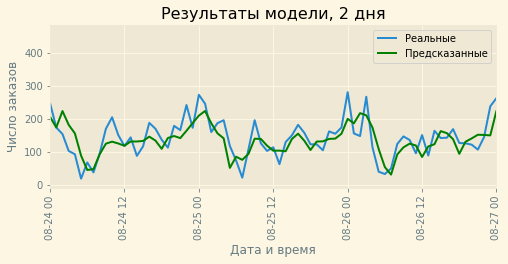

In [43]:
#Выведем предсказания лучшей модели
pred_1 = pd.Series(pred)
pred_1.index = test_y.index
pred_1.head()

datetime
2018-08-13 14:00:00    56.993703
2018-08-13 15:00:00    75.548344
2018-08-13 16:00:00    79.836838
2018-08-13 17:00:00    92.683827
2018-08-13 18:00:00    92.050060
Freq: H, dtype: float64

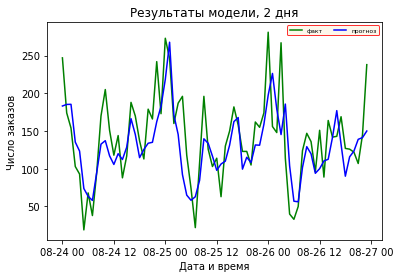

In [44]:
#Построим график  факт/предсказанное для того, чтобы увидеть отличия предсказания модели
# от фактического количества заказов такси
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(test_y['2018-08-24 00:00:00':'2018-08-26 23:59:59'], label = 'факт', color = 'g')
ax.plot(pred_1['2018-08-24 00:00:00':'2018-08-26 23:59:59'], label = 'прогноз', color='b')
plt.title('Результаты модели, 2 дня')
plt.ylabel('Число заказов')
plt.xlabel('Дата и время')
ax.legend(fontsize = 6,
          ncol = 6,    #  количество столбцов
          facecolor = 'oldlace',    #  цвет области
          edgecolor = 'r',    #  цвет крайней линии
          title_fontsize = '6'    #  размер шрифта заголовка
         )


Как видно из графика, модель предсказывает более усредненные значения и не предсказывает отдельные очень большие пики.

***Вывод***  
Исходя из вышеизложенного, построили модель для прогнозироания временных рядов, протестировали ее на тестовой выборке, и получили результат RMSE = 43.09020564135432, при этом, модель предсказывает более усредненные значения и не предсказывает одельные очень большие пики.